In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns

from bs4 import BeautifulSoup

In [2]:
with open('./residents-subzone-2017.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

In [3]:
placemarks = [placemark for placemark in soup.find_all('Placemark')]

In [4]:
print(len(placemarks))

323


In [5]:
# reading one datapoint
sample = [
placemarks[0].get('id'),
placemarks[0].snippet,
# placemarks[0].description,
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"HDB"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"ONE_TO_TWO_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"THREE_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FOUR_RM"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FIVE_RM_EXEC_FLATS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"CONDOS_OTHER_APTS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"LANDED_PROPERTIES"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"OTHERS"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"INC_CRC"}),
placemarks[0].ExtendedData.SchemaData.find("SimpleData", {"name":"FMEL_UPD_D"}),
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")],
# [[float(num) for num in pt.split(",")] 
#  for pt in placemarks[26].Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
]
sample

['kml_1',
 <snippet> </snippet>,
 <SimpleData name="SUBZONE_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="PLN_AREA_N">MARINA SOUTH</SimpleData>,
 <SimpleData name="TOTAL">0</SimpleData>,
 <SimpleData name="HDB">0</SimpleData>,
 <SimpleData name="ONE_TO_TWO_RM">0</SimpleData>,
 <SimpleData name="THREE_RM">0</SimpleData>,
 <SimpleData name="FOUR_RM">0</SimpleData>,
 <SimpleData name="FIVE_RM_EXEC_FLATS">0</SimpleData>,
 <SimpleData name="CONDOS_OTHER_APTS">0</SimpleData>,
 <SimpleData name="LANDED_PROPERTIES">0</SimpleData>,
 <SimpleData name="OTHERS">0</SimpleData>,
 <SimpleData name="INC_CRC">A414A47E5AA4EDB5</SimpleData>,
 <SimpleData name="FMEL_UPD_D">20170927160941</SimpleData>]

In [6]:
# pm.ExtendedData.decompose()
# pm.description.decompose()
# pm.text[14:].strip().split(" ")

In [7]:
placemark_data = []

for placemark in placemarks:
    val_TOTAL = int(placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"TOTAL"}).text)
    val_SUBZONE_N = placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"SUBZONE_N"}).text
    val_PLN_AREA_N = placemark.ExtendedData.SchemaData.find("SimpleData", {"name":"PLN_AREA_N"}).text
    placemark.ExtendedData.decompose()
    placemark.description.decompose()
    placemark_data.append([
        placemark.get('id'),
        val_TOTAL,
        val_SUBZONE_N,
        val_PLN_AREA_N,
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.text.strip().replace("\n\n\n\n\n", " ").split(" ")]
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.Polygon.outerBoundaryIs.LinearRing.text.strip().split(" ")]
#         [[float(num) for num in pt.split(",")] 
#          for pt in placemark.text[14:].strip().replace("\n\n\n\n\n", " ").split(" ")]
        [[[float(num) for num in pt.split(",")] 
          for pt in ring.split(" ")] 
         for ring in placemark.text[14:].strip().split("\n\n\n\n\n")]
    ])

In [8]:
df = pd.DataFrame(placemark_data, columns=["id", "TOTAL", "SUBZONE_N", "PLN_AREA_N", "boundary"])

In [9]:
sum(df["TOTAL"])

3966030

## Calculate the centre of subzone

In [10]:
def centre_boundary(boundary):
    boundary = sum(row["boundary"], [])  # flatten one level
    x_mean = sum([b[0] for b in boundary])/len(boundary)
    y_mean = sum([b[1] for b in boundary])/len(boundary)
    return x_mean, y_mean

In [11]:
df["x_centre"] = np.nan
df["y_centre"] = np.nan

In [12]:
for index, row in df.iterrows():
    x_mean, y_mean = centre_boundary(row["boundary"])
    df.at[index, "x_centre"] = x_mean
    df.at[index, "y_centre"] = y_mean

In [13]:
df.sample(5)

,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre
101,kml_102,2690,MALCOLM,NOVENA,"[[[103.841941225894, 1.32609151247944, 0.0], [...",103.834158,1.321659
104,kml_105,0,JURONG PORT,JURONG EAST,"[[[103.711866723174, 1.29861361987863, 0.0], [...",103.714776,1.306431
318,kml_319,710,WESTERN WATER CATCHMENT,WESTERN WATER CATCHMENT,"[[[103.693015269304, 1.43367231433362, 0.0], [...",103.671108,1.392225
126,kml_127,8870,MOULMEIN,NOVENA,"[[[103.848520391611, 1.32203635774028, 0.0], [...",103.842022,1.317900
91,kml_92,230,NATIONAL UNIVERSITY OF S'PORE,QUEENSTOWN,"[[[103.785274405113, 1.29325787835709, 0.0], [...",103.773813,1.294077


## Display histogram

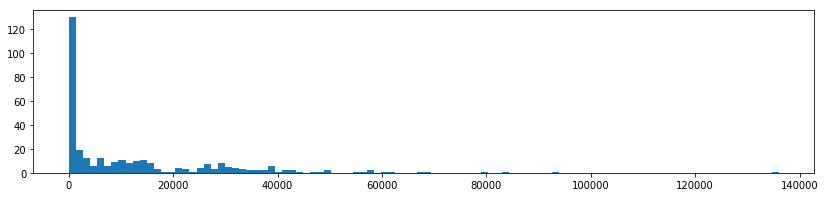

46

In [30]:
plt.figure(figsize=(14,3))
plt.hist(df["TOTAL"], bins=100)
plt.show()
len([x for x in df["TOTAL"] if x > 30000])

## Display map

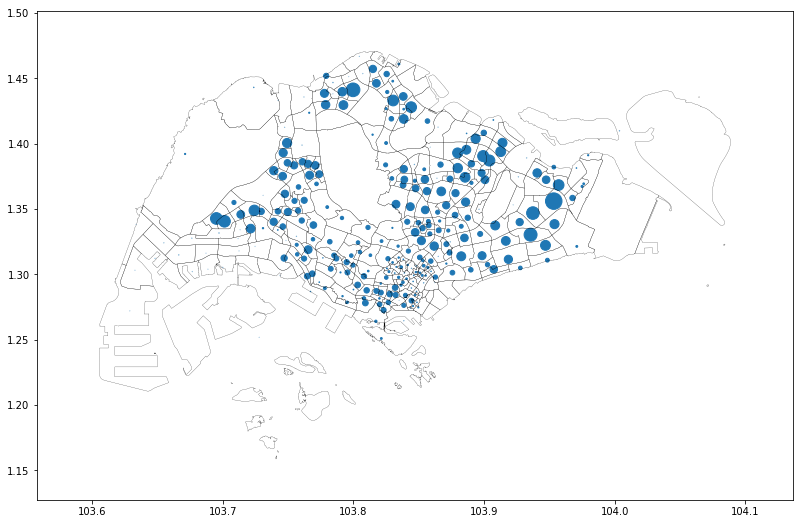

In [15]:
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for rings in df["boundary"]:
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()

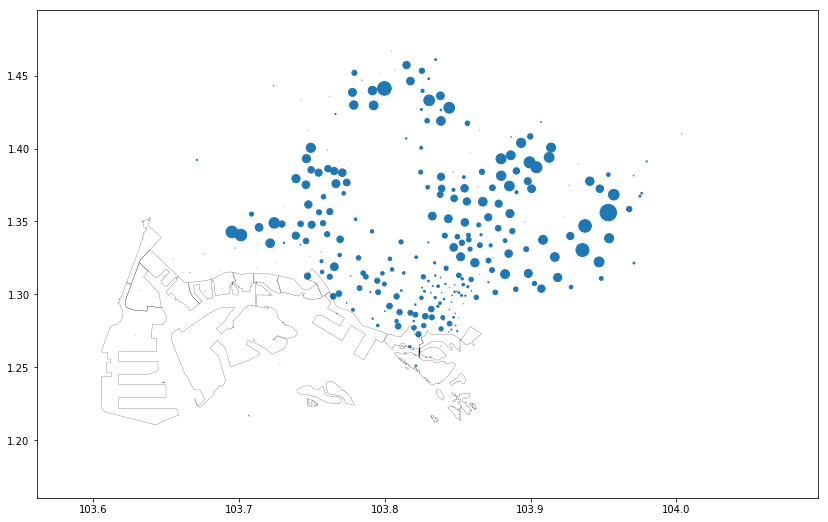

In [16]:
# probably should combine al this subzone into one
lst = [25,28,29,30,32,33,70,74,84,85,105,106,107,111,119,136,141,165]
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for i,rings in enumerate(df["boundary"]):
    if i+1 not in lst:
        continue
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()

## Identify adjacent subzones

In [17]:
df["adjacent"] = [[] for x in df["id"]]

In [18]:
from collections import defaultdict

d_pts = defaultdict(set)

for index, row in df.iterrows():
    for ring in row["boundary"]:
        for pt in ring:
            d_pts[(pt[0],pt[1])].add(index)

In [19]:
for index, row in df.iterrows():
    adj_set = set()
    for ring in row["boundary"]:
        for pt in ring:
            adj_set |= d_pts[(pt[0],pt[1])]    
    df.at[index, "adjacent"] = list(adj_set)

In [20]:
df.sample(5)

,id,TOTAL,SUBZONE_N,PLN_AREA_N,boundary,x_centre,y_centre,adjacent
164,kml_165,10,TUAS PROMENADE,TUAS,"[[[103.638569082314, 1.35084549493536, 0.0], [...",103.633665,1.338245,"[164, 73, 140, 241, 118, 318, 159]"
171,kml_172,6120,SUNSET WAY,CLEMENTI,"[[[103.767069593432, 1.3312024575101, 0.0], [1...",103.769000,1.326945,"[129, 202, 171, 205, 111, 177, 116, 246]"
224,kml_225,0,PLAB,PAYA LEBAR,"[[[103.916440527242, 1.34767684903436, 0.0], [...",103.909335,1.356315,"[224, 193, 225, 227, 165, 200, 233, 150]"
103,kml_104,136050,TAMPINES EAST,TAMPINES,"[[[103.960885879748, 1.36060465118094, 0.0], [...",103.953300,1.356111,"[257, 259, 103, 168, 142, 143, 214, 215, 222]"
259,kml_260,1480,CHANGI WEST,CHANGI,"[[[103.973327332819, 1.38925599697994, 0.0], [...",103.976217,1.369416,"[288, 257, 259, 103, 142, 308, 212, 254]"


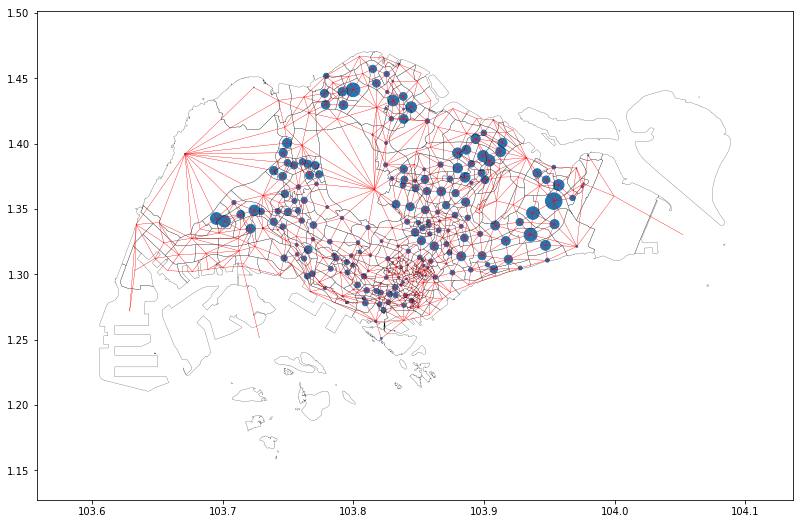

In [21]:
fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(df["x_centre"], df["y_centre"], df["TOTAL"]/500)
lines = []
for i,rings in enumerate(df["boundary"]):
    for b in rings:
        n = len(b)
        for e,_ in enumerate(b):
            lines.append([[b[e%n][0], b[e%n][1]], [b[(e+1)%n][0], b[(e+1)%n][1]]])
lc = mc.LineCollection(lines, colors="black", linewidths=0.2)
ax.add_collection(lc)

lines_adj = []
for i,adjacent in enumerate(df["adjacent"]):
    for adj in adjacent:
        lines_adj.append([[df["x_centre"][i], df["y_centre"][i]], 
                          [df["x_centre"][adj], df["y_centre"][adj]]])
lc_adj = mc.LineCollection(lines_adj, colors="red", linewidths=0.2)
ax.add_collection(lc_adj)

ax.autoscale()
ax.set_aspect(1)
ax.margins(0.1)
plt.show()

In [22]:
## Adjacency matrix

In [23]:
matrix = np.zeros((df.shape[0],df.shape[0]))
for i,adjacent in enumerate(df["adjacent"]):
    for adj in adjacent:
        matrix[i,adj] = np.log(1+df["TOTAL"][i]*df["TOTAL"][adj])

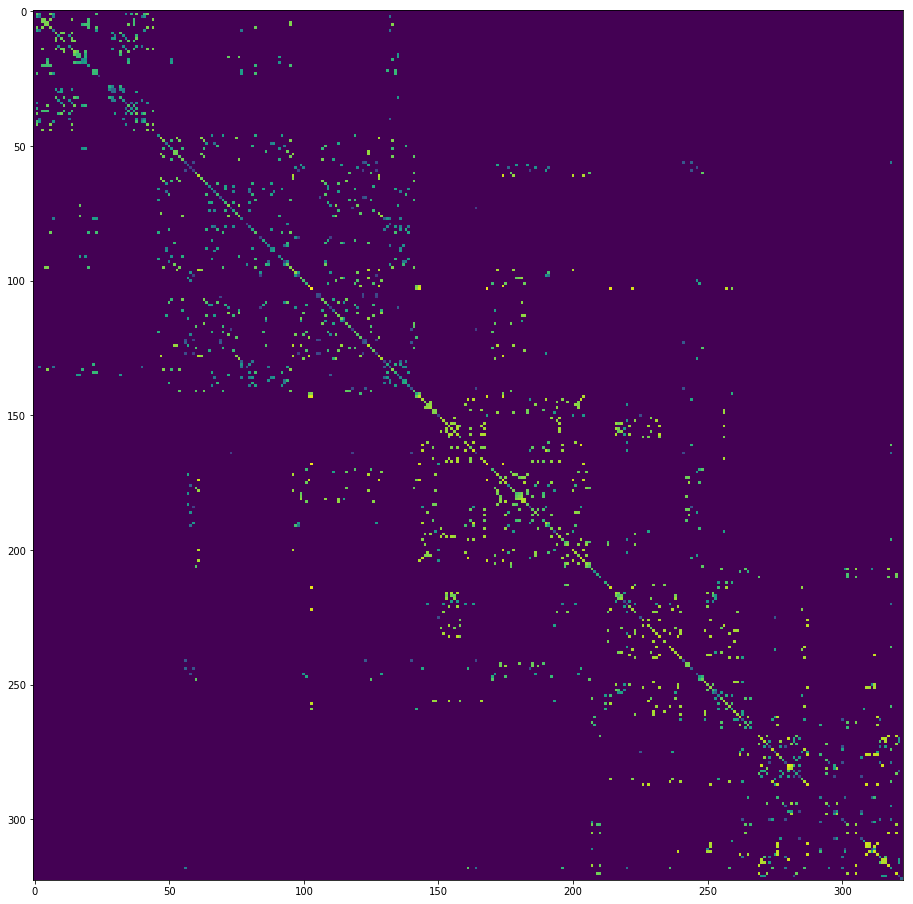

In [24]:
fig, ax = plt.subplots(figsize=(16,16))
ax = plt.imshow(matrix)
plt.show()